# Libraries 

In [32]:
import numpy as np
import glob
import cv2

import torch
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset preparation 

In [33]:
#MNIST Const
width = 28
height = 28
channels = 1
epochs = 50

# number of subprocesses to use for data loading
num_workers = 2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# how many samples per batch to load
batch_size = 64

# get the training datasets
train_data = torchvision.datasets.MNIST(root= 'data', train=True,
                            download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle=True, num_workers=num_workers)

# Data visualization

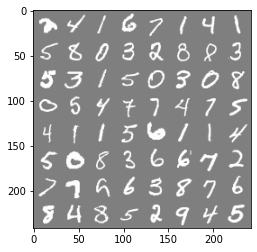

In [34]:
def imshow(img):
    img = img / 2 + 0.5             # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))

#DCGAN Model

In [35]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm

# Discriminator $D$

In [36]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # transpose conv layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(conv_dim, conv_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(conv_dim * 2, conv_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = output.view(-1, self.conv_dim*4*4*4)
        output = self.fc(output)
        return output

# Generator $G$

In [37]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = nn.Sequential(
            nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True)
        )
        self.t_conv2 = nn.Sequential(
            nn.ConvTranspose2d(conv_dim * 2, conv_dim , kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True)
        )
        self.t_conv3 = nn.Sequential(
            nn.ConvTranspose2d(conv_dim, 1 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        

    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        out = self.t_conv1(out)
        out = self.t_conv2(out)
        out = self.t_conv3(out)
        return out

# Build up Network

In [38]:
# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim = conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.

# GPU Training

In [39]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


# Discriminator and Generator Losses

In [40]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

# Optimizers

In [41]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

# Training

In [42]:
import pickle as pkl

# training hyperparams
num_epochs = 30

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

G.train()
D.train()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = real_images * 2 - 1
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   30] | d_loss: 1.4194 | g_loss: 0.7482
Epoch [    1/   30] | d_loss: 0.3273 | g_loss: 2.1186
Epoch [    1/   30] | d_loss: 0.2187 | g_loss: 2.4700
Epoch [    1/   30] | d_loss: 0.2559 | g_loss: 3.2401
Epoch [    2/   30] | d_loss: 0.3208 | g_loss: 3.4005
Epoch [    2/   30] | d_loss: 0.2632 | g_loss: 2.5068
Epoch [    2/   30] | d_loss: 0.2698 | g_loss: 2.2841
Epoch [    2/   30] | d_loss: 1.2921 | g_loss: 0.1587
Epoch [    3/   30] | d_loss: 0.2561 | g_loss: 3.2978
Epoch [    3/   30] | d_loss: 0.1848 | g_loss: 3.0912
Epoch [    3/   30] | d_loss: 0.5748 | g_loss: 1.7388
Epoch [    3/   30] | d_loss: 0.2162 | g_loss: 2.4398
Epoch [    4/   30] | d_loss: 0.5293 | g_loss: 0.6763
Epoch [    4/   30] | d_loss: 0.6985 | g_loss: 0.7418
Epoch [    4/   30] | d_loss: 0.4188 | g_loss: 1.3113
Epoch [    4/   30] | d_loss: 0.3187 | g_loss: 3.8564
Epoch [    5/   30] | d_loss: 0.2435 | g_loss: 2.7092
Epoch [    5/   30] | d_loss: 0.3040 | g_loss: 2.8536
Epoch [    5/   30] | d_loss

# Training Loss

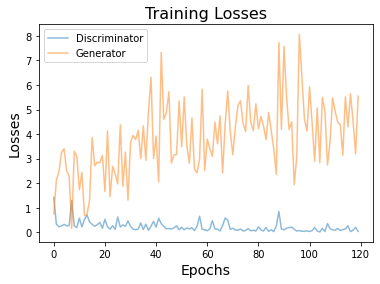

In [43]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.title("Training Losses", fontsize=16)
plt.legend()

# Generator samples from training

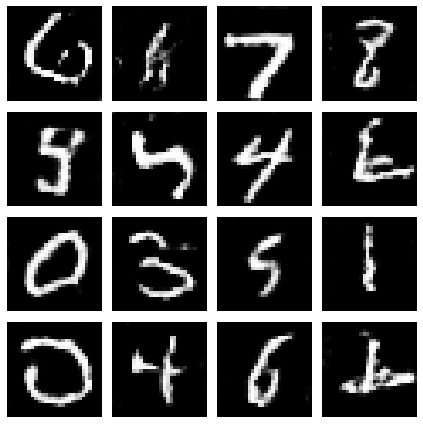

In [44]:
z = torch.Tensor(np.random.normal(0, 1, (16, 100))).cuda()
fake_images = G(z)
images = fake_images.data.cpu().numpy()
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()